Genís Lloses 218873 <br>
Bernat Treserres 217387 <br>
Carla Souto 218871

In [191]:
import nltk
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import json
import math
import re
import numpy as np
import collections
from numpy import linalg as la
import time
import pandas as pd
import collections

## PART 1

### Text Processing

In [3]:
docs_path = 'dataset_tweets_WHO.txt'
with open(docs_path) as fp:
    tweets = json.loads(fp.read())

In [4]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            u"\U00002700-\U000027BF"  # Dingbats
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_symbols_and_links(text):
    text = re.sub('https://.*', '', text) # to remove the links
    text = re.sub('http://.*', '', text)
    for ch in ['&',':','.',',',';','…','-','!','?','¿','amp','rt','"',"'"]:
        if ch in text:
            text = text.replace(ch, '')
    return text

def build_terms(line):
    """
    Preprocess the article text (title + body) removing stop words, stemming,
    transforming in lowercase and return the tokens of the text.
    
    Argument:
    line -- string (text) to be preprocessed
    
    Returns:
    line - a list of tokens corresponding to the input text after the preprocessing
    """

    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))
    ## START CODE
    line= line.lower() ## Transform in lowercase
    line= remove_emoji(line) ## remove emojis
    line= remove_symbols_and_links(line) ## remove symbols and links
    line= line.split() ## Tokenize the text to get a list of terms
    hashtags= [l.replace('#', '') for l in line if '#' in l] # we separate the hashtags
    line= [l for l in line if l not in stop_words and l.replace('#', '') not in hashtags and len(l)>1] ## eliminate the stopwords (HINT: use List Comprehension)
    line= [stemmer.stem(l) for l in line] ## perform stemming for the keywords
    hashtags= [stemmer.stem(l) for l in hashtags] ## perform stemming for the hashtags
    ## END CODE
    return line, hashtags


In [5]:
tweets_keywords = {}

for key in tweets.keys():
    tweets_keywords[int(key)] = build_terms(tweets[key]['full_text'])

In [6]:
#An example of how the list is stored (in this case, for the last word of the dictionary)

print(tweets['2398']['full_text']) # the full text of the tweet
tweets_keywords[2398] # the list of keywords and hastags of that tweet

The right to health means the right to control one’s health and body – including the sexual and reproductive health rights of women and girls – without interference https://t.co/0xs5xwkoTg 

#HealthForAll #StandUp4HumanRights https://t.co/qfh5PQ8S2D


(['right',
  'health',
  'mean',
  'right',
  'control',
  'one’',
  'health',
  'bodi',
  'includ',
  'sexual',
  'reproduct',
  'health',
  'right',
  'women',
  'girl',
  'without',
  'interfer'],
 ['healthforal', 'standup4humanright'])

## PART 2

### Indexing

In [7]:
def create_index(tweets):
    """
    Implement the inverted index
    
    Argument:
    lines -- collection of Wikipedia articles
    
    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of documents where these keys appears in (and the positions) as values.
    """
    keywords_index = defaultdict(list)
    hashtags_index = defaultdict(list)

    for tweet_id in tweets.keys():  # Remember, lines contain all documents
        tweet = tweets[tweet_id]["full_text"]
        keywords, hashtags = build_terms(tweet)
         
        ## ===============================================================        
        ## create the index for the current page and store it in current_page_index (current_page_index)
        ## current_page_index ==> { ‘term1’: [current_doc, [list of positions]], ...,‘term_n’: [current_doc, [list of positions]]}

        ## Example: if the curr_doc has id 1 and his text is 
        ##"web retrieval information retrieval":

        ## current_page_index ==> { ‘web’: [1, [0]], ‘retrieval’: [1, [1,4]], ‘information’: [1, [2]]}

        ## the term ‘web’ appears in document 1 in positions 0, 
        ## the term ‘retrieval’ appears in document 1 in positions 1 and 4
        ## ===============================================================

        current_tweet_keyword_index = {}
        current_tweet_hashtag_index = {}

        for position, keyword in enumerate(keywords): # terms contains page_title + page_text. Loop over all terms
            try:
                # if the term is already in the index for the current page (current_page_index)
                # append the position to the corresponding list
                
                current_tweet_keyword_index[keyword][1].append(position)  
                
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_tweet_keyword_index[keyword]=[tweet_id, [position]] #'I' indicates unsigned int (int in Python)
            
        #merge the current page index with the main index
        for keyword, info in current_tweet_keyword_index.items():
            keywords_index[keyword].append(info)
        
        
        for position, hashtag in enumerate(hashtags): # terms contains page_title + page_text. Loop over all terms
            try:
                # if the term is already in the index for the current page (current_page_index)
                # append the position to the corresponding list
                
                current_tweet_hashtag_index[hashtag][1].append(position) 
                
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_tweet_hashtag_index[hashtag]=[tweet_id, [position]] #'I' indicates unsigned int (int in Python)
            
        #merge the current page index with the main index
        for hashtag, info in current_tweet_hashtag_index.items():
            hashtags_index[keyword].append(info)
        
                    
    return keywords_index, hashtags_index

In [8]:
tweets_info = {}

for tweet_id in tweets.keys():
    tweet_info = {}
    tweet_info["Tweet"] = tweets[tweet_id]["full_text"]
    tweet_info["Username"] = tweets[tweet_id]["user"]["screen_name"]
    tweet_info["Date"] = tweets[tweet_id]["created_at"]
    tweet_info["Hashtags"] = tweets[tweet_id]["entities"]["hashtags"]
    tweet_info["Likes"] = tweets[tweet_id]["favorite_count"]
    tweet_info["Retweets"] = tweets[tweet_id]["retweet_count"]
    try:
        tweet_info["Url"] = tweets[tweet_id]["entities"]["urls"][0]["url"]
    except:
        tweet_info["Url"] = "No Url :("
    
    tweets_info[int(tweet_id)] = tweet_info

### TF-IDF

In [9]:
# CREC Q EN COMPTES DE PASSARLI TWEETS PODEM PASSAR EL NUM DE TWEETS PERO BUENO


def create_index_tfidf(num_tweets, index):
    """
    Implement the inverted index and compute tf, df and idf
    
    Argument:
    lines -- collection of Wikipedia articles
    numDocuments -- total number of documents
    
    Returns:
    index - the inverted index (implemented through a python dictionary) containing terms as keys and the corresponding 
    list of document these keys appears in (and the positions) as values.
    tf - normalized term frequency for each term in each document
    df - number of documents each term appear in
    idf - inverse document frequency of each term
    """ 
        
    tf=defaultdict(list) #term frequencies of terms in documents (documents in the same order as in the main index)
    df=defaultdict(int)         #document frequencies of terms in the corpus
    idf=defaultdict(float)
        
    #normalize term frequencies
    # Compute the denominator to normalize term frequencies (formula 2 above)
    # norm is the same for all terms of a document.
    norm=0
    for term, values in index.items(): 
        # posting is a list containing doc_id and the list of positions for current term in current document: 
        # posting ==> [currentdoc, [list of positions]] 
        # you can use it to inferr the frequency of current term.
        for tweet in values:
            norm+=len(tweet[1])**2 # numbers of appearances of a term 
    norm=math.sqrt(norm)


    #calculate the tf(dividing the term frequency by the above computed norm) and df weights
    for term, values in index.items():     
        # append the tf for current term (tf = term frequency in current doc/norm)
        for tweet in values:
            tf[term].append(np.round(len(tweet[1])/norm,4))  ## SEE formula (1) above
        #increment the document frequency of current term (number of documents containing the current term)
        df[term]= len(index[term])  # increment df for current term


    # Compute idf following the formula (3) above. HINT: use np.log
    for term in df:
        idf[term] = np.round(np.log(float(num_tweets/df[term])),4)
            
    return tf, df, idf


In [10]:
start_time = time.time()
num_tweets = len(tweets)

keywords_index, hashtags_index = create_index(tweets)

tf_k, df_k, idf_k = create_index_tfidf(len(tweets), keywords_index)
tf_h, df_h, idf_h = create_index_tfidf(len(tweets), hashtags_index)

print("Total time to create the index: {} seconds" .format(np.round(time.time() - start_time, 2)))

Total time to create the index: 2.37 seconds


### Evaluation

In [28]:
def rank_tweets(terms, tweets, index, idf, tf):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    title_index -- mapping between page id and page title
    
    Returns:
    Print the list of ranked documents
    """

    # I'm interested only on the element of the docVector corresponding to the query terms 
    # The remaining elements would became 0 when multiplied to the query_vector
    tweet_vectors = defaultdict(lambda: [0] * len(terms)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)


    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query. 
    # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})
    #HINT: use when computing tf for query_vector

    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue

        ## Compute tf*idf(normalize TF as done with documents)
        query_vector[termIndex]= query_terms_count[term]/query_norm * idf[term]
        
        # Generate doc_vectors for matching docs
        for tweet_index, (tweet, postings) in enumerate(index[term]):
            # Example of [doc_index, (doc, postings)]
            # 0 (26, array('I', [1, 4, 12, 15, 22, 28, 32, 43, 51, 68, 333, 337]))
            # 1 (33, array('I', [26, 33, 57, 71, 87, 104, 109]))
            # term is in doc 26 in positions 1,4, .....
            # term is in doc 33 in positions 26,33, .....

            #tf[term][0] will contain the tf of the term "term" in the doc 26            
            if tweet in tweets:
                tweet_vectors[tweet][termIndex] = tf[term][tweet_index] * idf[term]  # TODO: check if multiply for idf

    # Calculate the score of each doc 
    # compute the cosine similarity between queryVector and each tweetVector:
    # HINT: you can use the dot product because in case of normalized vectors it corresponds to the cosine similarity
    # see np.dot
    
    tweet_scores=[[np.dot(curTweetVec, query_vector), tweet] for tweet, curTweetVec in tweet_vectors.items() ]
    tweet_scores.sort(reverse=True)
    result_tweets = [x[1] for x in tweet_scores]
    #print document titles instead if document id's
    #result_docs=[ title_index[x] for x in result_docs ]
    if len(result_tweets) == 0:
        print("No results found, try again")
        query = input()
        docs = search_tf_idf(query, index)
    #print ('\n'.join(result_docs), '\n')
    return result_tweets


In [29]:
def search_tf_idf(query, index):
    """
    output is the list of documents that contain any of the query terms. 
    So, we will get the list of documents for each query term, and take the union of them.
    """
    query = build_terms(query)[0]
    tweets = set()
    for term in query:
        try:
            # store in term_tweets the ids of the tweets that contain "term"                        
            term_tweets = []
            for posting in index[term]:
                term_tweets.append(posting[0])
            
            # tweets = tweets Union term_tweets
            tweets = tweets.union(term_tweets)
        except:
            #term is not in index
            pass
    tweets = list(tweets)
    ranked_tweets = rank_tweets(query, tweets, index, idf_k, tf_k)
    return ranked_tweets

#### QUERY 1

In [70]:
relevance_dict = {}

print("Insert your query (i.e.: Computer Science):\n")
query = input()
ranked_tweets = search_tf_idf(query, keywords_index)
top = 10

relevance_dict["q1"] = {"tweets_id": ranked_tweets[:top], "relevance": [0,0,1,1,0,0,1,1,0,0]} 

print("\n======================\nTop {} results out of {} for the searched query:\n======================\n".format(top, len(ranked_tweets)))
for t_id in ranked_tweets[:top]:
    print("tweet_id= {}\ntweet: {}\n".format(t_id, tweets[str(t_id)]['full_text']))
    print("--------------------------------------------------------------------------")
    

Insert your query (i.e.: Computer Science):

covid vaccine

Top 10 results out of 427 for the searched query:

tweet_id= 61
tweet: RT @WHOPhilippines: Vaccines can’t stop #COVID19 alone, but by doing it all we can help protect ourselves and our loved ones against COVID-…

--------------------------------------------------------------------------
tweet_id= 200
tweet: 🆕 WHO clinical case definition for post #COVID19 condition, also called 'long COVID' https://t.co/WoiLcwsgJX https://t.co/Z0olrHlWPC

--------------------------------------------------------------------------
tweet_id= 1561
tweet: If you have recovered from #COVID19 but are still experiencing certain symptoms you could have post COVID-19 condition or "long COVID". What are these symptoms? How long do they last and are there any treatment options? Dr @diazjv explains in #ScienceIn5 ⬇️ https://t.co/vtDiBhZsJE

--------------------------------------------------------------------------
tweet_id= 1110
tweet: To facilitate effect

#### QUERY 2

In [74]:
print("Insert your query (i.e.: Computer Science):\n")
query = input()
ranked_tweets = search_tf_idf(query, keywords_index)
top = 10

relevance_dict["q2"] = {"tweets_id": ranked_tweets[:top], "relevance": [1,1,0,1,0,0,0,1,0,1,0]} 

print("\n======================\nTop {} results out of {} for the searched query:\n======================\n".format(top, len(ranked_tweets)))
for t_id in ranked_tweets[:top]:
    print("tweet_id= {}\ntweet: {}\n".format(t_id, tweets[str(t_id)]['full_text']))
    print("--------------------------------------------------------------------------")


Insert your query (i.e.: Computer Science):

hospital doctor

Top 10 results out of 59 for the searched query:

tweet_id= 823
tweet: RT @WHOWPRO: Gatsengel of #Mongolia is an intensive care doctor who lost his grandmother to #COVID19. Yet, loyal to his oath and motivated…

--------------------------------------------------------------------------
tweet_id= 663
tweet: A brain drain in #Lebanon is occurring at alarming speed. Almost 40% of skilled medical doctors and almost 30% of registered nurses have already left the country either permanently or temporarily. https://t.co/xvrdG3Ir0g https://t.co/JuC5teKsOJ

--------------------------------------------------------------------------
tweet_id= 654
tweet: RT @DrTedros: Very touched with meeting in person Afghan evacuees in 🇶🇦. Some are journalists, doctors &amp; artists. I met their children too.…

--------------------------------------------------------------------------
tweet_id= 569
tweet: @DrTedros @WHOEMRO "There's a serious shortage

#### QUERY 3

In [75]:
print("Insert your query (i.e.: Computer Science):\n")
query = input()
ranked_tweets = search_tf_idf(query, keywords_index)
top = 10

relevance_dict["q3"] = {"tweets_id": ranked_tweets[:top], "relevance": [0,0,0,0,0,0,0,0,0,0]} 

print("\n======================\nTop {} results out of {} for the searched query:\n======================\n".format(top, len(ranked_tweets)))
for t_id in ranked_tweets[:top]:
    print("tweet_id= {}\ntweet: {}\n".format(t_id, tweets[str(t_id)]['full_text']))
    print("--------------------------------------------------------------------------")

Insert your query (i.e.: Computer Science):

fast food

Top 10 results out of 57 for the searched query:

tweet_id= 2026
tweet: Food systems &amp; health are connected:
 
🔀 from those who work 👩🏽‍🌾 in our food systems
🔀 the practices used to grow, raise, transport package &amp; dispose of our food
🔀 to the quality, quantity &amp; safety of the food we eat
 
More info 👉https://t.co/uCqRGjlf3P https://t.co/73YoAlI87v

--------------------------------------------------------------------------
tweet_id= 883
tweet: To keep food safe at home, follow WHO 5 Keys to Safer Food: 
1️⃣ Keep clean 
2️⃣ Separate raw and cooked 
3️⃣ Cook thoroughly 
4️⃣ Keep food at safe temperature 
5️⃣ Use safe water and raw materials

#SafeFood https://t.co/ppX7O2Jpk7

--------------------------------------------------------------------------
tweet_id= 955
tweet: RT @DrTedros: Viruses move fast, but data can move even faster. With the right information, countries &amp; communities can stay ahead of emerg…

-------

#### QUERY 4

In [71]:
print("Insert your query (i.e.: Computer Science):\n")
query = input()
ranked_tweets = search_tf_idf(query, keywords_index)
top = 10

relevance_dict["q4"] = {"tweets_id": ranked_tweets[:top], "relevance": [0,0,1,0,0,1,1,0,1,1]} 

print("\n======================\nTop {} results out of {} for the searched query:\n======================\n".format(top, len(ranked_tweets)))
for t_id in ranked_tweets[:top]:
    print("tweet_id= {}\ntweet: {}\n".format(t_id, tweets[str(t_id)]['full_text']))
    print("--------------------------------------------------------------------------")

Insert your query (i.e.: Computer Science):

covid symptoms

Top 10 results out of 20 for the searched query:

tweet_id= 1561
tweet: If you have recovered from #COVID19 but are still experiencing certain symptoms you could have post COVID-19 condition or "long COVID". What are these symptoms? How long do they last and are there any treatment options? Dr @diazjv explains in #ScienceIn5 ⬇️ https://t.co/vtDiBhZsJE

--------------------------------------------------------------------------
tweet_id= 700
tweet: If you are pregnant &amp; #COVID19 positive:
 
⏳ Seek medical care early
📞 Ask your health worker for advice on managing symptoms
🏥 Know where to go if your symptoms worsen
🗓️ Isolate yourself https://t.co/8Yq1BrmJ9l

--------------------------------------------------------------------------
tweet_id= 311
tweet: Today is #WorldHeartDay ♥️
 
Know the symptoms of heart attack and #stroke
 
If you are experiencing any of these symptoms, seek medical care immediately.
⬇️ https://t.co/u1K

#### QUERY 5

In [72]:
print("Insert your query (i.e.: Computer Science):\n")
query = input()
ranked_tweets = search_tf_idf(query, keywords_index)
top = 10

relevance_dict["q5"] = {"tweets_id": ranked_tweets[:top], "relevance": [0,0,1,1,0,0,1,1,0,0]} 

print("\n======================\nTop {} results out of {} for the searched query:\n======================\n".format(top, len(ranked_tweets)))
for t_id in ranked_tweets[:top]:
    print("tweet_id= {}\ntweet: {}\n".format(t_id, tweets[str(t_id)]['full_text']))
    print("--------------------------------------------------------------------------")

Insert your query (i.e.: Computer Science):

sport injuries

Top 10 results out of 21 for the searched query:

tweet_id= 1909
tweet: @Olympics @DrTedros @Tokyo2020 "Sport and all forms of physical activity are essential for good health. By its very nature, sport is about participation, bringing individuals, communities and countries together, and bridging cultural, ethnic and national divides"-@DrTedros #Tokyo2020 #AGoal4All

--------------------------------------------------------------------------
tweet_id= 699
tweet: 🆕 WHO/@ILO study reveals that almost 2⃣ million people were killed by work-related diseases &amp; injuries in 2016.

Find out more in the first WHO/ILO Joint Estimates of the Work-related Burden of Disease and Injury 👉https://t.co/mEXoBqYt5g #WorkersHealth https://t.co/fV8nJWkNb2

--------------------------------------------------------------------------
tweet_id= 1908
tweet: @Olympics @DrTedros @Tokyo2020 "Sport promotes tolerance and respect, &amp; empowers women &amp

In [81]:
data = pd.DataFrame(columns = ['q_id', 'tweet_id', "relevant"])

queries = []
tweets = []
relevances = []

for key in relevance_dict.keys():
    for i in range(10):
        queries.append(key)
        tweets.append(relevance_dict[key]["tweets_id"][i])
        relevances.append(relevance_dict[key]["relevance"][i])

data['q_id'] = queries
data['tweet_id'] = tweets
data['relevant'] = relevances
data

,q_id,tweet_id,relevant
0,q1,61,0
1,q1,200,0
2,q1,1561,1
3,q1,1110,1
4,q1,904,0
5,q1,510,0
6,q1,509,1
7,q1,2001,1
8,q1,1968,0
9,q1,164,0


In [114]:
def precision_at_k(y_true, k=10):
    '''    
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.
    
    Returns
    -------
    precision @k : float
    
    '''    
    relevant = y_true[:k]
    
    cont = 0
    for rel in relevant:
        if rel == 1:
            cont += 1
    
    return cont/k


In [115]:
k=7

prec_at_q_1 = precision_at_k(data[data["q_id"]=="q1"]["relevant"], k)
prec_at_q_2 = precision_at_k(data[data["q_id"]=="q2"]["relevant"], k)
prec_at_q_3 = precision_at_k(data[data["q_id"]=="q3"]["relevant"], k)
prec_at_q_4 = precision_at_k(data[data["q_id"]=="q4"]["relevant"], k)
prec_at_q_5 = precision_at_k(data[data["q_id"]=="q5"]["relevant"], k)


print("Precision at query {}: {}".format("q1",prec_at_q_1))
print("Precision at query {}: {}".format("q2",prec_at_q_2))
print("Precision at query {}: {}".format("q3",prec_at_q_3))
print("Precision at query {}: {}".format("q4",prec_at_q_4))
print("Precision at query {}: {}".format("q5",prec_at_q_5))

Precision at query q1: 0.42857142857142855
Precision at query q2: 0.42857142857142855
Precision at query q3: 0.0
Precision at query q4: 0.42857142857142855
Precision at query q5: 0.42857142857142855


In [126]:
def avg_precision_at_k(y_true, k=10):
    
    '''
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.
    
    Returns
    -------
    average precision @k : float
    '''
    
    gtp = np.sum(y_true)           

    ## if all docs are not relevant
    if gtp==0:
        return 0
    
    n_relevant_at_i = 0
    prec_at_i = 0
    for i in range(len(y_true)):
        if y_true[i] == 1:
            prec_at_i += precision_at_k(y_true, i+1)
            
    return prec_at_i/gtp

In [127]:
k=7

avg_prec_at_q_1 = avg_precision_at_k(list(data[data["q_id"]=="q1"]["relevant"]), k)
avg_prec_at_q_2 = avg_precision_at_k(list(data[data["q_id"]=="q2"]["relevant"]), k)
avg_prec_at_q_3 = avg_precision_at_k(list(data[data["q_id"]=="q3"]["relevant"]), k)
avg_prec_at_q_4 = avg_precision_at_k(list(data[data["q_id"]=="q4"]["relevant"]), k)
avg_prec_at_q_5 = avg_precision_at_k(list(data[data["q_id"]=="q5"]["relevant"]), k)


print("Average precision at query {}: {}".format("q1",avg_prec_at_q_1))
print("Average precision at query {}: {}".format("q2",avg_prec_at_q_2))
print("Average precision at query {}: {}".format("q3",avg_prec_at_q_3))
print("Average precision at query {}: {}".format("q4",avg_prec_at_q_4))
print("Average precision at query {}: {}".format("q5",avg_prec_at_q_5))

Average precision at query q1: 0.44047619047619047
Average precision at query q2: 0.75
Average precision at query q3: 0
Average precision at query q4: 0.40793650793650793
Average precision at query q5: 0.44047619047619047


In [137]:
def map_at_k(data, k=10):
    '''
    Parameters
    ----------
    search_res: search results dataset containing:
        q_id: query id.
        doc_id: document id.
        predicted_relevance: relevance predicted through LightGBM.
        y_true: actual score of the document for the query (ground truth).
    
    Returns
    -------
    mean average precision @k : float
    '''
    avp = []
    for q in np.unique(data["q_id"]): #loop over all query id
        curr_data = data[data["q_id"] == q]["relevant"]  # select data for current query
        avp.append(avg_precision_at_k(list(curr_data),k)) #append average precision for current query
    return  np.sum(avp)/len(avp)  # return mean average precision

In [139]:
map_k = map_at_k(data, 10)

print("Mean Average precision: {}".format(map_k))

Mean Average precision: 0.40777777777777774


In [145]:
def rr_at_k(y_true, k=10):
    '''
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: we have already ordered the relevance array
    k : number of doc to consider.
    
    Returns
    -------
    Reciprocal Rank for qurrent query
    '''

    if np.sum(y_true) == 0: # if there are not relevant doument return 0
        return 0
    
    if y_true.index(1)+1 > k:
        return 0
    
    return  1/(y_true.index(1)+1) # hint: to get the position of the first relevant document use "np.argmax"



In [146]:
rr = rr_at_k(list(data[data["q_id"]=="q5"]["relevant"]))

rr

0.3333333333333333

In [149]:
mrr = {}
for k in [3,5,10]:
    RRs = []
    for q in np.unique(data["q_id"]): # loop over all query ids
        RRs.append(rr_at_k(list(data[data["q_id"]== q]["relevant"]),k)) # append RR for current query
    mrr[k] = np.round(np.sum(RRs)/len(np.unique(data["q_id"])),4) # Mean RR at current k
                      
mrr                      

{3: 0.4, 5: 0.4, 10: 0.4}

In [204]:
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_20newsgroups
import re
import matplotlib.pyplot as plt

In [275]:
words_count = collections.Counter()
for tweet in tweets_keywords.values():
    words_count += collections.Counter(tweet[0])

model = Word2Vec(words_count)
X = model.wv[model.wv.key_to_index]

tsne = TSNE(perplexity=5, n_components=2)
X_tsne = tsne.fit_transform(X)


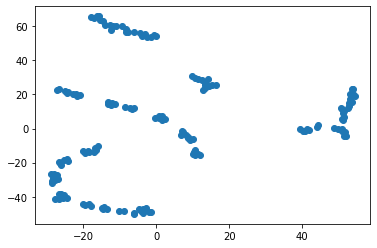

In [278]:
plt.scatter(X_tsne[:,0], X_tsne[:,1])

plt.show()